In [39]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
import os
import h5py
import numpy
import pandas as pd
import pylab as plt
from bilby.core.prior import MultivariateGaussian, MultivariateGaussianDist, PriorDict
import numpy as np
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
import pycbc.conversions as convert
import bilby
import pycbc
import seaborn as sns

## Load FM errors

In [40]:
def decode_data(data):
    """
    Decodes byte strings or arrays of byte strings from HDF5.
    """
    if isinstance(data, bytes):
        return data.decode('utf-8')
    elif isinstance(data, np.ndarray) and data.dtype.kind in {'S', 'O'}:
        return [d.decode('utf-8') if isinstance(d, bytes) else d for d in data]
    else:
        return data

def load_from_h5_group(group):
    """
    Recursively loads data from an HDF5 group and reconstructs Python objects.
    """
    result = {}

    # Check if this group is an array-style list (all keys are numeric)
    keys = list(group.keys())
    if all(k.isdigit() for k in keys):
        # Treat it as a list, sorted by numeric key
        items = []
        for key in sorted(keys, key=lambda x: int(x)):
            val = group[key]
            if isinstance(val, h5py.Group):
                items.append(load_from_h5_group(val))
            else:
                items.append(decode_data(val[()]))
        return items

    # Otherwise treat as dict
    for key in group:
        item = group[key]
        if isinstance(item, h5py.Group):
            result[key] = load_from_h5_group(item)
        else:
            result[key] = decode_data(item[()])

    return result

def load_results_from_h5(filename):
    """
    Loads structured data from a universally saved HDF5 file.
    """
    with h5py.File(filename, 'r') as f:
        return load_from_h5_group(f)

In [41]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
#mass_band = 'below_40'
#mass_band = '40-80'
mass_band = 'above_80'
#fm_err_file = os.path.join(base_dir, 'GWBench_analysis', 'BBH', 'mass_bands',
#                           f'CE4020ET123_CoBA10_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_set3_pop_from_XPHM_{mass_band}.h5')
fm_err_file = os.path.join(base_dir, 'GWBench_analysis', 'BBH', 'mass_bands',
                           f'LHI_Asharp_1_PLP_z_MD_zmax_6_lmrd_22_no_spins_all_events_365_days_pop_from_XPHM_{mass_band}.h5')

In [42]:
with h5py.File(fm_err_file, 'r') as f:
    print(f['all_inj_params_original']['0'].keys())
    print(f['all_inj_params_original']['0']['q'][()])

<KeysViewHDF5 ['SNR_H1', 'SNR_I1', 'SNR_L1', 'SNR_mf_H1', 'SNR_mf_I1', 'SNR_mf_L1', 'SNR_mf_from_opt_H1', 'SNR_mf_from_opt_I1', 'SNR_mf_from_opt_L1', 'SNR_mf_from_opt_network', 'SNR_mf_network', 'SNR_network', 'chi_1_in_plane', 'chi_2_in_plane', 'chi_eff', 'chi_p', 'coa_phase', 'cos_spin1_polar', 'cos_spin2_polar', 'dec', 'delta_f', 'distance', 'eta', 'f_final', 'f_lower', 'f_ref', 'inclination', 'index', 'mass1', 'mass2', 'mchirp', 'mtotal', 'old_index', 'phi_12', 'phi_jl', 'polarization', 'q', 'ra', 'redshift', 'spin1_a', 'spin1_azimuthal', 'spin1_polar', 'spin1x', 'spin1y', 'spin1z', 'spin2_a', 'spin2_azimuthal', 'spin2_polar', 'spin2x', 'spin2y', 'spin2z', 'srcmass1', 'srcmass2', 'srcmchirp', 'srcmtotal', 'theta_jn', 'time_interval', 'trigger_time']>
1.5630301033290541


In [43]:
fm_results = load_results_from_h5(fm_err_file)

In [44]:
num_events = len(fm_results['cov'])
num_events

186

In [45]:
for key,val in fm_results.items():
    if type(val[0]) == dict:
        fm_results[key] = pd.DataFrame(fm_results[key])

In [46]:
fm_results['errs']['DL'] = fm_results['errs']['log_DL']*fm_results['inj_params']['DL']

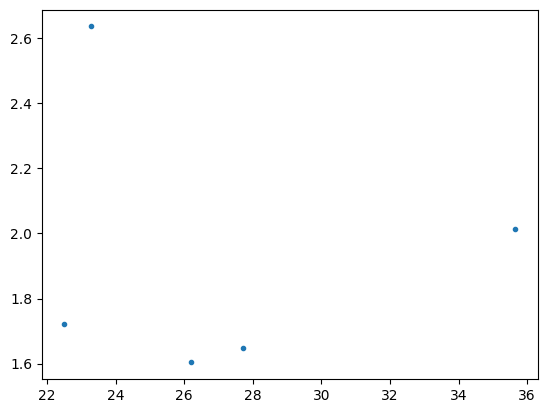

In [47]:
mask = (fm_results['all_inj_params_original']['SNR_network'] > 20) & (fm_results['all_inj_params_original']['SNR_network']/fm_results['errs']['snr'] > 1.5)
plt.plot(fm_results['all_inj_params_original']['SNR_network'][mask], fm_results['all_inj_params_original']['SNR_network'][mask]/fm_results['errs']['snr'][mask], '.')
#plt.axvline(12, color='k')
#plt.axhline(1, color='k')

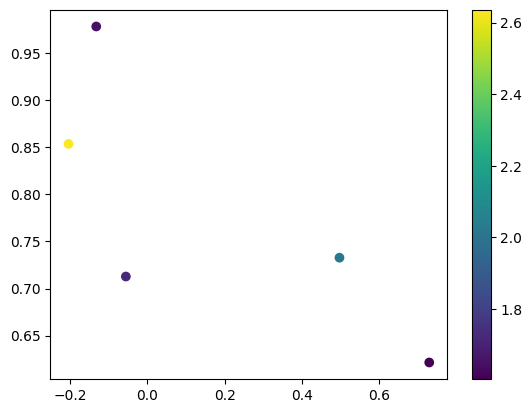

In [48]:
plt.scatter(fm_results['all_inj_params_original']['chi_eff'][mask], 
            fm_results['all_inj_params_original']['chi_p'][mask],
            c=fm_results['all_inj_params_original']['SNR_network'][mask]/fm_results['errs']['snr'][mask]
            )
#plt.axvline(12, color='k')
#plt.axhline(1, color='k')
plt.colorbar()

## Convert logDL and logMc to DL and Mc

In [49]:
def transform_cov_logDL_logMc_to_DL_Mc(cov, DL, logDL_index, Mc, logMc_index):
    """
    Transforms a covariance matrix where:
    - log_DL is replaced with DL using dDL/dlogDL = DL
    - log_Mc is replaced with M_c using dMc/dlogMc = Mc

    Parameters:
    -----------
    cov : np.ndarray
        Original NxN covariance matrix including log_DL and log_Mc.
    DL : float
        Mean value of DL (Mpc).
    logDL_index : int
        Index of log_DL in the covariance matrix.
    Mc : float
        Mean value of chirp mass (solar masses).
    logMc_index : int
        Index of log_Mc in the covariance matrix.

    Returns:
    --------
    cov_new : np.ndarray
        Transformed covariance matrix with DL and M_c replacing log_DL and log_Mc.
    """

    # Derivatives for Jacobian (from chain rule)
    dDL_dlogDL = DL
    dMc_dlogMc = Mc

    # Build Jacobian matrix
    N = cov.shape[0]
    J = np.eye(N)
    J[logDL_index, logDL_index] = dDL_dlogDL
    J[logMc_index, logMc_index] = dMc_dlogMc

    # Transform covariance matrix
    cov_new = J @ cov @ J.T

    return cov_new

### Convert cov matrices to new cov matrices

In [50]:
transform_cov_logDL_logMc_to_DL_Mc

<function __main__.transform_cov_logDL_logMc_to_DL_Mc(cov, DL, logDL_index, Mc, logMc_index)>

In [51]:
log_DL_idx = fm_results['deriv_variables_in_order'].index('log_DL')
log_Mc_idx = fm_results['deriv_variables_in_order'].index('log_Mc')
fm_results['new_cov'] = []
for i in range(len(fm_results['cov'])):
    new_cov = transform_cov_logDL_logMc_to_DL_Mc(fm_results['cov'][i], 
                                                 fm_results['inj_params']['DL'][i], 
                                                 log_DL_idx, 
                                                 fm_results['inj_params']['Mc'][i],
                                                 log_Mc_idx)
    fm_results['new_cov'].append(new_cov)
fm_results['new_deriv_variables_in_order'] = []

for var in fm_results['deriv_variables_in_order']:
    if var == 'log_DL':
        fm_results['new_deriv_variables_in_order'].append('DL')
    elif var == 'log_Mc':
        fm_results['new_deriv_variables_in_order'].append('Mc')
    else:
        fm_results['new_deriv_variables_in_order'].append(var)

## Create posterior samples

In [52]:
fm_results['deriv_variables_in_order']

['log_Mc', 'eta', 'log_DL', 'iota', 'tc', 'phic', 'ra', 'dec', 'psi']

In [53]:
convert.eta_from_q(20)

0.045351473922902494

In [54]:
param_bounds = {
    'Mc':[4.35, np.inf],
    'log_Mc':[np.log(4.35), np.inf],
    'eta':[0.0454, 0.25],
    'DL':[1, np.inf],
    'log_DL':[0, np.inf],
    'iota':[0, np.pi],
    'tc':[-np.inf, np.inf],
    'ra':[0, 2*np.pi],
    'dec':[-np.pi/2, np.pi/2],
    'psi':[0, 2*np.pi]
}

if max(fm_results['inj_params']['phic']) > np.pi:
    param_bounds['phic'] = [0, 2*np.pi]
else:    
    param_bounds['phic'] = [-np.pi, np.pi]

In [55]:
param_bounds

{'Mc': [4.35, inf],
 'log_Mc': [1.4701758451005926, inf],
 'eta': [0.0454, 0.25],
 'DL': [1, inf],
 'log_DL': [0, inf],
 'iota': [0, 3.141592653589793],
 'tc': [-inf, inf],
 'ra': [0, 6.283185307179586],
 'dec': [-1.5707963267948966, 1.5707963267948966],
 'psi': [0, 6.283185307179586],
 'phic': [0, 6.283185307179586]}

### Create posteriors using injected values as mean

In [17]:
import logging
logging.getLogger('bilby').setLevel(logging.ERROR)
n_samples = 5000
n_events = len(fm_results['new_cov'])

posterior_samples_all_events = {}

for event in tqdm(range(n_events)):
    mu = [fm_results['inj_params'][param][event] for param in fm_results['new_deriv_variables_in_order']]
    cov = fm_results['new_cov'][event]  # the covariance matrix
    mvg = MultivariateGaussianDist(fm_results['new_deriv_variables_in_order'], mus=mu, covs=cov, 
                                   bounds=[param_bounds[param] for param in fm_results['new_deriv_variables_in_order']])
    posterior_dists_i = dict()
    posterior_samples_i = {}
    for param in ['Mc', 'eta', 'DL']:
        posterior_dists_i[param] = MultivariateGaussian(mvg, param)
        posterior_samples_i[param] = posterior_dists_i[param].sample(n_samples)
    posterior_samples_all_events[f'event_{event}'] = posterior_samples_i

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [05:36<00:00,  4.46it/s]


### Create posterior using jittered mean values for each parameter

In order to induce noise in the posterior, the following steps are followed:
1. Multivariate gaussian (MVG) is created taking true value as mean
2. One random sample is drawn for each parameter from the MVG. This sample becomes the new mean mimicking the effect of gaussian noise.
3. New gaussian is created taking the above value as the new mean

#### Using transformed cov matrices

In [73]:
import logging
logging.getLogger('bilby').setLevel(logging.ERROR)
n_events = len(fm_results['new_cov'])
fm_results['new_mean_vals'] = {}
for event in tqdm(range(n_events)):
    mu = [fm_results['inj_params'][param][event] for param in fm_results['new_deriv_variables_in_order']]
    cov = fm_results['new_cov'][event]  # the covariance matrix
    mvg = MultivariateGaussianDist(fm_results['new_deriv_variables_in_order'], mus=mu, covs=cov, 
                                   bounds=[param_bounds[param] for param in fm_results['new_deriv_variables_in_order']])
    new_mean_vals = dict()
    for param in fm_results['new_deriv_variables_in_order']:
        new_mean_vals[param] = MultivariateGaussian(mvg, param).sample()
    fm_results['new_mean_vals'][f'event_{event}'] = new_mean_vals

KeyError: 'new_cov'

In [37]:
n_samples = 5000
n_events = len(fm_results['new_cov'])

posterior_samples_all_events = {}

for event in tqdm(range(n_events)):
    mu = [fm_results['new_mean_vals'][f'event_{event}'][param] for param in fm_results['new_deriv_variables_in_order']]
    cov = fm_results['new_cov'][event]  # the covariance matrix
    mvg = MultivariateGaussianDist(fm_results['new_deriv_variables_in_order'], mus=mu, covs=cov, 
                                   bounds=[param_bounds[param] for param in fm_results['new_deriv_variables_in_order']])
    posterior_dists_i = dict()
    posterior_samples_i = {}
    for param in ['Mc', 'eta', 'DL']:
        posterior_dists_i[param] = MultivariateGaussian(mvg, param)
        posterior_samples_i[param] = posterior_dists_i[param].sample(n_samples)
    posterior_samples_all_events[f'event_{event}'] = posterior_samples_i

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [05:26<00:00,  4.60it/s]


#### Using un-transformed cov matrices

In [56]:
fm_results['inj_params'].keys()

Index(['DL', 'Mc', 'chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec',
       'eta', 'iota', 'phic', 'psi', 'ra', 'tc', 'z'],
      dtype='object')

In [57]:
fm_results['inj_params']['log_Mc'] = np.log(fm_results['inj_params']['Mc'])
fm_results['inj_params']['log_DL'] = np.log(fm_results['inj_params']['DL'])

#### Remove problematic events

In [18]:
problematic_events = [1467] # M<20
num_events = num_events - len(problematic_events)

In [19]:
fm_results.keys()

dict_keys(['all_inj_params_original', 'cov', 'deriv_variables_in_order', 'errs', 'inj_params'])

In [20]:
[type(val) for val in fm_results.values()]

[pandas.core.frame.DataFrame,
 list,
 list,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame]

In [21]:
for key, val in fm_results.items():
    if 'variables' in key or 'new_mean' in key:
        continue
    elif key == 'cov':
        for idx in sorted(problematic_events, reverse=True):
            del fm_results[key][idx]
    else:
        fm_results[key] = val.drop(index=problematic_events).reset_index()

In [22]:
[len(val) for val in fm_results.values()]

[2340, 2340, 9, 2340, 2340]

#### Continue

In [62]:
import logging
logging.getLogger('bilby').setLevel(logging.ERROR)
n_events = len(fm_results['cov'])
fm_results['new_mean_vals'] = {}
for event in tqdm(range(n_events)):
    mu = [fm_results['inj_params'][param][event] for param in fm_results['deriv_variables_in_order']]
    cov = fm_results['cov'][event]  # the covariance matrix
    mvg = MultivariateGaussianDist(fm_results['deriv_variables_in_order'], mus=mu, covs=cov, 
                                   bounds=[param_bounds[param] for param in fm_results['deriv_variables_in_order']])
    new_mean_vals = dict()
    for param in fm_results['deriv_variables_in_order']:
        new_mean_vals[param] = MultivariateGaussian(mvg, param).sample()
    fm_results['new_mean_vals'][f'event_{event}'] = new_mean_vals

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 511.39it/s]


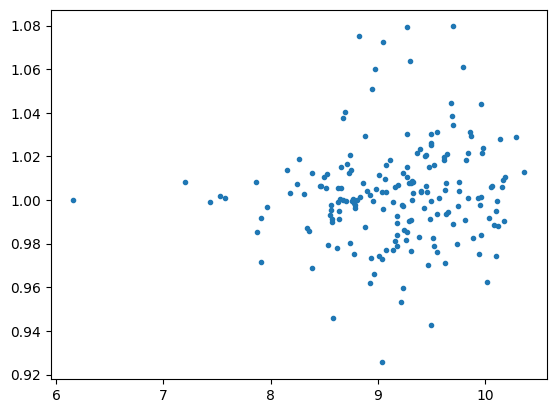

In [63]:
plt.plot(fm_results['inj_params']['log_DL'], 
         fm_results['inj_params']['log_DL']/[fm_results['new_mean_vals'][i]['log_DL'] for i in fm_results['new_mean_vals'].keys()], 
         '.');

#### Save new means to h5

In [64]:
def save_to_h5_group(group, data, string_dtype):
    """
    Recursively saves Python data structures (dicts, lists, arrays, scalars) to an HDF5 group.
    """
    if isinstance(data, dict):
        for key, value in data.items():
            sub_key = str(key)
            if isinstance(value, (dict, list, tuple)):
                subgroup = group.create_group(sub_key)
                save_to_h5_group(subgroup, value, string_dtype)
            elif isinstance(value, str):
                group.create_dataset(sub_key, data=value, dtype=string_dtype)
            else:
                group.create_dataset(sub_key, data=np.array(value))
    elif isinstance(data, (list, tuple)):
        for i, item in enumerate(data):
            item_key = str(i)
            if isinstance(item, (dict, list, tuple)):
                subgroup = group.create_group(item_key)
                save_to_h5_group(subgroup, item, string_dtype)
            elif isinstance(item, str):
                group.create_dataset(item_key, data=item, dtype=string_dtype)
            else:
                group.create_dataset(item_key, data=np.array(item))
    elif isinstance(data, str):
        group.create_dataset("value", data=data, dtype=string_dtype)
    else:
        group.create_dataset("value", data=np.array(data))


def save_results_to_h5(results, filename):
    """
    Saves arbitrary nested results dictionary to an HDF5 file.
    """
    dt = h5py.string_dtype(encoding='utf-8')
    with h5py.File(filename, 'w') as f:
        save_to_h5_group(f, results, dt)

In [65]:
fm_err_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWBench_analysis/BBH/mass_bands/LHI_Asharp_1_PLP_z_MD_zmax_6_lmrd_22_no_spins_all_events_365_days_pop_from_XPHM_above_80.h5'

In [66]:
new_fm_file = fm_err_file.replace('.h5', '_with_new_means3.h5')
new_fm_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWBench_analysis/BBH/mass_bands/LHI_Asharp_1_PLP_z_MD_zmax_6_lmrd_22_no_spins_all_events_365_days_pop_from_XPHM_above_80_with_new_means3.h5'

In [67]:
save_results_to_h5(fm_results, new_fm_file)

### Create posteriors

In [68]:
n_samples = 10000
n_events = len(fm_results['cov'])

posterior_samples_all_events = {}

for event in tqdm(range(n_events)):
    mu = [fm_results['new_mean_vals'][f'event_{event}'][param] for param in fm_results['deriv_variables_in_order']]
    cov = fm_results['cov'][event]  # the covariance matrix
    mvg = MultivariateGaussianDist(fm_results['deriv_variables_in_order'], mus=mu, covs=cov, 
                                   bounds=[param_bounds[param] for param in fm_results['deriv_variables_in_order']])
    posterior_dists_i = dict()
    posterior_samples_i = {}
    for param in ['log_Mc', 'eta', 'log_DL']:
        posterior_dists_i[param] = MultivariateGaussian(mvg, param)
        posterior_samples_i[param] = posterior_dists_i[param].sample(n_samples)
    posterior_samples_all_events[f'event_{event}'] = posterior_samples_i

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [01:05<00:00,  2.84it/s]


##### Add Mc and DL from log_Mc and log_DL

In [69]:
for event in posterior_samples_all_events.keys():
    posterior_samples_all_events[event]['Mc'] = np.exp(posterior_samples_all_events[event]['log_Mc'])
    posterior_samples_all_events[event]['DL'] = np.exp(posterior_samples_all_events[event]['log_DL'])

### Add m1, m2, q, z

In [70]:
for event in posterior_samples_all_events.keys():
    Mc = posterior_samples_all_events[event]['Mc']
    eta = posterior_samples_all_events[event]['eta']
    DL = posterior_samples_all_events[event]['DL']
    posterior_samples_all_events[event]['m1'] = convert.mass1_from_mchirp_eta(Mc, eta)
    posterior_samples_all_events[event]['m2'] = convert.mass2_from_mchirp_eta(Mc, eta)
    posterior_samples_all_events[event]['q_inv'] = convert.q_from_mass1_mass2(posterior_samples_all_events[event]['m1'],
                                                                              posterior_samples_all_events[event]['m2'])
    posterior_samples_all_events[event]['q'] = 1/posterior_samples_all_events[event]['q_inv']
    posterior_samples_all_events[event]['z'] = pycbc.cosmology.redshift(DL, cosmology='Planck18')

### Convert to bilby parameter names

In [71]:
posterior_samples_all_events['event_0'].keys()

dict_keys(['log_Mc', 'eta', 'log_DL', 'Mc', 'DL', 'm1', 'm2', 'q_inv', 'q', 'z'])

In [72]:
gwbench_to_bilby_name_map = {
    'Mc':'chirp_mass',
    'log_Mc':'log_chirp_mass',
    'eta':'symmetric_mass_ratio',
    'DL':'luminosity_distance',
    'log_DL':'log_luminosity_distance',
    'm1':'mass_1',
    'm2':'mass_2',
    'q_inv': 'inverted_mass_ratio',
    'z': 'redshift',
    'q': 'mass_ratio'
}

In [73]:
pos_samples_bilby_names = {}
for event in posterior_samples_all_events.keys():
    pos_samples_bilby_names[event] = {}
    for param in posterior_samples_all_events[event].keys():
        pos_samples_bilby_names[event][gwbench_to_bilby_name_map[param]] = posterior_samples_all_events[event][param]

#### Add source frame parameters

In [74]:
for event in pos_samples_bilby_names.keys():
    for param in ['mass_1', 'mass_2', 'chirp_mass']:
        pos_samples_bilby_names[event][param+'_source'] = pos_samples_bilby_names[event][param]/(1 + pos_samples_bilby_names[event]['redshift'])

In [75]:
pos_samples_bilby_names['event_0'].keys()

dict_keys(['log_chirp_mass', 'symmetric_mass_ratio', 'log_luminosity_distance', 'chirp_mass', 'luminosity_distance', 'mass_1', 'mass_2', 'inverted_mass_ratio', 'mass_ratio', 'redshift', 'mass_1_source', 'mass_2_source', 'chirp_mass_source'])

## Considering only redshift posterior for gwpop analysis

### Create prior on redshift

Since the posteriors were drawn from a Multivariate Gaussian created on $\mathcal{M}_c$, $eta$, and $D_L$, the priors are uniform on these parameters.

Hence,

$p(z) = p(D_L) \left| \frac{dD_L(z)}{dz} \right| \propto \left| \frac{dD_L(z)}{dz} \right|$

since $p(D_L) = const$

In [76]:
def calc_dDL_dz(DL_arr, z_arr):
    """
    Parameters: 
    ----------------------
    z_arr: numpy array
        redshift value
    DL_arr: numpy array
        Luminosity distance (Mpc)

    Returns:
    --------------------------
    dDL_dz : scipy.interpolate.UnivariateSpline
        Derivative spline giving dDL/dz
    """
    
    sort_idx = np.argsort(DL_arr)
    DL_sorted = DL_arr[sort_idx]
    z_sorted = z_arr[sort_idx]
    
    fDL = UnivariateSpline(z_sorted, DL_sorted, s=0)
    dfDL_dz = fDL.derivative()
    return(dfDL_dz)

In [77]:
DL_grid = np.linspace(1, 13e4, 10000)
z_grid = pycbc.cosmology.redshift(DL_grid, cosmology='Planck18')
print('z_max =', z_grid.max())
dDL_dz_interp = calc_dDL_dz(DL_grid, z_grid)

z_max = 11.979426122089338


In [78]:
posteriors_z_list = []
for event in pos_samples_bilby_names:
    zi = pos_samples_bilby_names[event]['redshift']
    prior_zi = dDL_dz_interp(zi)
    #prior_zi_normalized = prior_zi/np.trapz(prior_zi, zi)
    prior_zi_normalized = prior_zi/np.sum(prior_zi)
    event_i = {'redshift': zi,
               'prior': prior_zi_normalized}
    posteriors_z_list.append(pd.DataFrame(event_i))

### Save to pickle file

In [79]:
fm_err_file.split('/')[-1].split('_pop_from_XPHM')[0]

'LHI_Asharp_1_PLP_z_MD_zmax_6_lmrd_22_no_spins_all_events_365_days'

In [80]:
mass_band

'above_80'

In [81]:
# commented out to avoid accidental overwriting
pd.to_pickle(posteriors_z_list, os.path.join(base_dir, 'gwpopulation', 'BBH', 'mass_bands', 
                                             '_'.join([fm_err_file.split('/')[-1].split('_pop_from_XPHM')[0],  
                                                       'z_posteriors_10K_original_cov', 
                                                       f'{num_events}', 'events_pop_from_XPHM3', 
                                                       f'{mass_band}.pkl'])))

## Plot posteriors for redshift

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:13<00:00, 37.18it/s]


(0.0, 7.840914998983969)

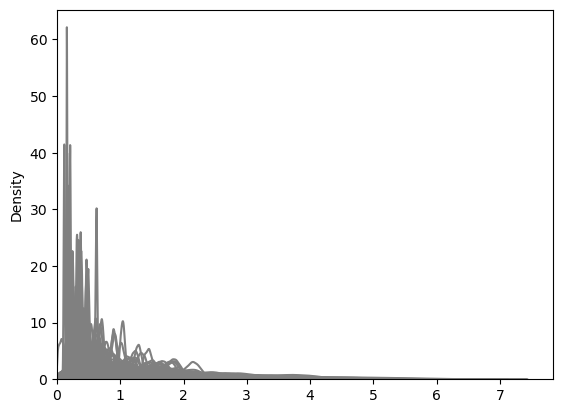

In [41]:
import seaborn as sns
warnings.filterwarnings(
    "ignore",
    message=".*use_inf_as_na option is deprecated.*",
    category=FutureWarning
)

for event in tqdm(list(posterior_samples_all_events.keys())):
    sns.kdeplot(posterior_samples_all_events[event]['z'], color='grey')
plt.xlim(0,)

## Convert DL errors to z

In [35]:
def calc_dz_dDL(z_arr, DL_arr):
    """
    Parameters: 
    ----------------------
    z_arr: numpy array
        redshift value
    DL_arr: numpy array
        Luminosity distance (Mpc)

    Returns:
    --------------------------
    delta_z_arr: dz_dDL : scipy.interpolate.UnivariateSpline
        Derivative spline giving dz/dDL
    """
    
    sort_idx = np.argsort(DL_arr)
    DL_sorted = DL_arr[sort_idx]
    z_sorted = z_arr[sort_idx]
    
    fz = UnivariateSpline(DL_sorted, z_sorted)
    dfz_dDL = fz.derivative()
    return(dfz_dDL)

In [15]:
def get_delta_z_from_delta_DL(z_arr, DL_arr, delta_DL_arr):
    """
    Parameters: 
    ----------------------
    z_arr: numpy array
        redshift value
    DL_arr: numpy array
        Luminosity distance (Mpc)
    delta_DL_arr: numpy array
        error on DL

    Returns:
    --------------------------
    delta_z_arr: numpy array
        error on z
    """
    
    dfz_dDL = calc_dz_dDL(z_arr, DL_arr)
    delta_z = dfz_dDL(DL_arr) * delta_DL_arr
    return(delta_z)

In [16]:
fm_results['errs']['z'] = get_delta_z_from_delta_DL(fm_results['inj_params']['z'], 
                                                    fm_results['inj_params']['DL'], 
                                                    fm_results['errs']['DL'])

In [17]:
fm_results['errs']['log_z'] = fm_results['errs']['z']/fm_results['inj_params']['z']

In [18]:
def transform_cov_logDL_logMc_to_z_Mc(cov, DL, dz_dDL, logDL_index, Mc, logMc_index):
    """
    Transforms a covariance matrix where:
    - log_DL is replaced with redshift using dz/dDL spline
    - log_Mc is replaced with M_c using exp transformation

    Parameters:
    -----------
    cov : np.ndarray
        Original NxN covariance matrix including log_DL and log_Mc.
    DL : float
        True or mean value of DL (Mpc).
    dz_dDL : scipy.interpolate.UnivariateSpline
        Derivative spline giving dz/dDL
    logDL_index : int
        Index of log_DL in the covariance matrix.
    Mc : float
        True or mean value of chirp mass.
    logMc_index : int
        Index of log_Mc in the covariance matrix.

    Returns:
    --------
    cov_new : np.ndarray
        Transformed covariance matrix with redshift and M_c replacing log_DL and log_Mc.
    """
    
    dz_dlogDL = dz_dDL(DL) * DL  # chain rule: dz/dlogDL = dz/dDL * DL
    dMc_dlogMc = Mc              # derivative of exp(log_Mc) is Mc

    # Build Jacobian matrix
    N = cov.shape[0]
    J = np.eye(N)
    J[logDL_index, logDL_index] = dz_dlogDL
    J[logMc_index, logMc_index] = dMc_dlogMc

    # Transform covariance
    cov_new = J @ cov @ J.T
    return cov_new

## Others

In [31]:
def transform_cov_Mc_det_to_src(cov, Mc_index, z_index, Mc_det_val, z_val):
    """
    Transforms the covariance matrix from detector-frame Mc to source-frame Mc.

    Parameters:
    -----------
    cov : np.ndarray
        NxN covariance matrix including Mc (det-frame) and z.
    Mc_index : int
        Index of detector-frame Mc in the covariance matrix.
    z_index : int
        Index of redshift in the covariance matrix.
    Mc_det_val : float
        Detector-frame chirp mass.
    z_val : float
        Redshift at which to evaluate the Jacobian.

    Returns:
    --------
    cov_new : np.ndarray
        Transformed covariance matrix with Mc_src instead of Mc_det.
    """

    N = cov.shape[0]
    J = np.eye(N)

    # Partial derivatives
    dMcsrc_dMcdet = 1 / (1 + z_val)
    dMcsrc_dz = -Mc_det_val / (1 + z_val)**2

    # Modify the Jacobian
    J[Mc_index, Mc_index] = dMcsrc_dMcdet
    J[Mc_index, z_index] = dMcsrc_dz

    # Apply Jacobian transformation
    cov_new = J @ cov @ J.T
    return cov_new

In [32]:
failed['new_cov_src_Mc'] = []
for event in range(499):
    new_cov = fm_results['new_cov'][event]
    new_cov_src_mc = transform_cov_Mc_det_to_src(new_cov, 
                                                 fm_results['new_deriv_variables_in_order'].index('Mc'), 
                                                 fm_results['new_deriv_variables_in_order'].index('z'),
                                                 fm_results['inj_params']['Mc'][event],
                                                 fm_results['inj_params']['z'][event])
    try:
        np.linalg.cholesky(new_cov_src_mc)
    except np.linalg.LinAlgError:
        failed['new_cov_src_Mc'].append(event)

In [34]:
len(list(failed['new_cov_src_Mc']))

67